<a href="https://colab.research.google.com/github/Saksham9804/Sentiment_Analysis_Project/blob/main/Twitter_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importing Libraries and Setting Environment

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os
import yfinance as yf

In [ ]:
# Setting plot style for consistent visuals
plt.style.use('ggplot')

##2. Loading and Cleaning Dataset

In [ ]:
# Reading the Twitter sentiment dataset
df = pd.read_csv('twitter_sentiment_data.csv')

In [ ]:
# Dropping specific stock symbols that will not be analyzed
df = df[~df['symbol'].isin(['ATVI', 'MRO'])]

In [ ]:
# Displaying a few rows to verify data
df.head()

,date,symbol,twitterPosts,twitterComments,twitterLikes,twitterImpressions,twitterSentiment
0,2021-11-18,AAPL,811.0,2592.0,21674.0,7981808.0,NaN
1,2021-11-18,ABT,21.0,3.0,13.0,64089.0,NaN
2,2021-11-18,AMD,150.0,675.0,2949.0,1645270.0,NaN
3,2021-11-18,AMZN,557.0,1315.0,12969.0,5590695.0,NaN
5,2021-11-18,BA,61.0,55.0,342.0,425847.0,NaN


In [ ]:
# Displaying available stock symbols
df['symbol']

,symbol
0,AAPL
1,ABT
2,AMD
3,AMZN
5,BA
...,...
27230,TMO
27231,TSLA
27232,TSN
27233,V


In [ ]:
# Checking data types and structure
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26487 entries, 0 to 27234
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                26487 non-null  object 
 1   symbol              26487 non-null  object 
 2   twitterPosts        26487 non-null  float64
 3   twitterComments     26487 non-null  float64
 4   twitterLikes        26487 non-null  float64
 5   twitterImpressions  26487 non-null  float64
 6   twitterSentiment    22364 non-null  float64
dtypes: float64(5), object(2)
memory usage: 2.6+ MB


In [ ]:
# Getting summary statistics of numeric fields
df.describe()

,twitterPosts,twitterComments,twitterLikes,twitterImpressions,twitterSentiment
count,26487.000000,2.648700e+04,2.648700e+04,2.648700e+04,22364.000000
mean,549.662098,1.032002e+05,2.498216e+05,3.793865e+06,0.540410
std,1520.986817,1.602644e+06,3.208289e+06,1.247213e+07,0.071470
min,21.000000,0.000000e+00,0.000000e+00,8.880000e+02,0.000000
25%,74.000000,8.700000e+01,3.795000e+02,3.097085e+05,0.521655
50%,182.000000,7.070000e+02,3.352000e+03,9.128500e+05,0.553596
75%,468.500000,4.530500e+03,2.103800e+04,2.705278e+06,0.578313
max,47044.000000,1.014674e+08,1.786642e+08,4.881733e+08,0.813610


##3. Preprocessing and Feature Engineering


In [ ]:
# Converting the 'date' column to datetime format for time-based grouping
df['date'] = pd.to_datetime(df['date'])

In [ ]:
# Setting a hierarchical index (date, symbol) for multi-level analysis
df = df.set_index(['date', 'symbol'])

In [ ]:
# Calculating engagement ratio to identify genuine social activity
# Engagement ratio = twitterComments / twitterLikes
df['engagement_ratio'] = df['twitterComments'] / df['twitterLikes']

In [ ]:
# Filtering out tweets with very few likes or comments (low engagement)
df = df[(df['twitterLikes'] > 20) & (df['twitterComments'] > 10)]

In [ ]:
# Checking structure after filtering
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24709 entries, (Timestamp('2021-11-18 00:00:00'), 'AAPL') to (Timestamp('2023-01-04 00:00:00'), 'XOM')
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   twitterPosts        24709 non-null  float64
 1   twitterComments     24709 non-null  float64
 2   twitterLikes        24709 non-null  float64
 3   twitterImpressions  24709 non-null  float64
 4   twitterSentiment    20838 non-null  float64
 5   engagement_ratio    24709 non-null  float64
dtypes: float64(6)
memory usage: 1.2+ MB


##4. Monthly Aggregation and Ranking

In [ ]:
# Aggregating average engagement ratio on a monthly basis for each symbol
aggregated_df = (df.reset_index('symbol')
                   .groupby([pd.Grouper(freq='M'), 'symbol'])[['engagement_ratio']]
                   .mean())

/tmp/ipython-input-1254376860.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby([pd.Grouper(freq='M'), 'symbol'])[['engagement_ratio']]


In [ ]:
# Ranking companies within each month by engagement ratio (descending)
aggregated_df['rank'] = aggregated_df.groupby(level=0)['engagement_ratio'] \
                                     .transform(lambda x: x.rank(ascending=False))

In [ ]:
# Displaying the ranked monthly engagement data
aggregated_df

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  70.0
           TSN             0.280553  29.0
           V               0.194045  58.0
           XOM             0.217904  51.0

[1081 rows x 2 columns]

## 5. Selecting Top 5 Stocks Each Month

In [ ]:
# Filtering only top 5 ranked stocks per month
filtered_df = aggregated_df[aggregated_df['rank'] < 6]

In [ ]:
# Resetting symbol index for time offset adjustments
filtered_df = filtered_df.reset_index(level=1)

In [ ]:
# Moving selection date to the first day of next month (when portfolio forms)
filtered_df.index = filtered_df.index + pd.DateOffset(1)

In [ ]:
# Re-indexing properly by date and symbol
filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])
filtered_df.head(20)

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
2022-01-01 D               0.801994   5.0
           FCX             0.841220   4.0
           L               6.507246   1.0
           LUV             1.303215   2.0
           MA              0.883401   3.0
2022-02-01 AMD             0.715556   4.0
           D               1.136678   1.0
           FCX             0.655237   5.0
           LUV             1.035258   2.0
           MA              0.729063   3.0
2022-03-01 D               0.496694   5.0
           FCX             1.138332   2.0
           GILD            0.530886   4.0
           LUV             1.574377   1.0
           OXY             1.025579   3.0

##6. Creating Monthly Portfolio Dictionary

In [ ]:
# Extracting unique monthly start dates
dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {}

In [ ]:
# Creating dictionary mapping each start date to selected top 5 stocks
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

In [ ]:
# Displaying portfolio composition for all months
fixed_dates

{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['D', 'FCX', 'GILD', 'LUV', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

##7. Downloading Stock Price Data

In [ ]:
# Listing all unique symbols from dataset
stock_list = df.index.get_level_values('symbol').unique().tolist()

In [ ]:
# Downloading stock prices for all relevant symbols
stock_data = yf.download(tickers=stock_list, start='2021-01-01', end='2023-03-01')

/tmp/ipython-input-1746714823.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(tickers=stock_list, start='2021-01-01', end='2023-03-01')
[*********************100%***********************]  83 of 83 completed


In [ ]:
# Calculating daily log returns for each stock
return_df = np.log(stock_data['Close']).diff().dropna()
print(return_df)

Ticker             A       AAL       AAP      AAPL      ABBV       ABT  \
Date                                                                     
2021-01-05  0.008143  0.019634 -0.001081  0.012288  0.010288  0.012297   
2021-01-06  0.027053  0.005816  0.056165 -0.034241 -0.008676 -0.002085   
2021-01-07  0.026261 -0.009062  0.008505  0.033554  0.010646  0.009660   
2021-01-08  0.007109 -0.016388  0.014154  0.008594  0.005234  0.002781   
2021-01-11  0.008542 -0.008629  0.005629 -0.023524  0.016182 -0.006923   
...              ...       ...       ...       ...       ...       ...   
2023-02-22 -0.009387 -0.008320 -0.003961  0.002892 -0.008788 -0.009305   
2023-02-23  0.007852  0.019727 -0.011273  0.003285  0.009249 -0.001364   
2023-02-24 -0.014065 -0.019727 -0.022503 -0.018169  0.004200 -0.020591   
2023-02-27  0.006916  0.004489  0.012738  0.008214  0.010228 -0.006892   
2023-02-28 -0.001478  0.022146  0.030326 -0.003454 -0.002466  0.019356   

Ticker           AEP       AES       

##8. Building Equal-Weight Portfolios

In [ ]:
# Creating empty dataframe to collect monthly portfolio returns
portfolio_df = pd.DataFrame()

In [ ]:
# Looping through each start date to calculate portfolio performance
for start_date in fixed_dates.keys():
    # Determining month-end date for the same period
    end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    cols = fixed_dates[start_date]

    # Averaging daily returns across selected stocks for equal weighting
    temp_df = return_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')

    # Appending monthly portfolio data
    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

In [ ]:
print(portfolio_df)

            portfolio_return
Date                        
2021-12-01         -0.016417
2021-12-02          0.024872
2021-12-03         -0.007711
2021-12-06          0.023926
2021-12-07          0.030547
...                      ...
2023-02-22         -0.007870
2023-02-23         -0.007323
2023-02-24         -0.009463
2023-02-27         -0.001871
2023-02-28          0.001403

[312 rows x 1 columns]


##9. Benchmark Comparison with NASDAQ

In [ ]:
qqq_df=yf.download(tickers='QQQ', start='2021-01-01', end='2023-03-01')

/tmp/ipython-input-3258383157.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  qqq_df=yf.download(tickers='QQQ', start='2021-01-01', end='2023-03-01')
[*********************100%***********************]  1 of 1 completed


In [ ]:
# Handling both MultiIndex and single-level data formats
if isinstance(qqq_df.columns, pd.MultiIndex):
    qqq_close = qqq_df[('Close', 'QQQ')]
else:
    qqq_close = qqq_df['Close']


In [ ]:
# Calculating daily log returns of NASDAQ benchmark
qqq_ret = np.log(qqq_close).diff().rename('nasdaq_return').to_frame()

In [ ]:
# Merging portfolio returns with benchmark returns
portfolio_df = portfolio_df.merge(qqq_ret, left_index=True, right_index=True, how='left')

##10. Cumulative Return Calculation and Visualization

In [ ]:
# Computing cumulative returns for both portfolio and NASDAQ benchmark
portfolios_cumlative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

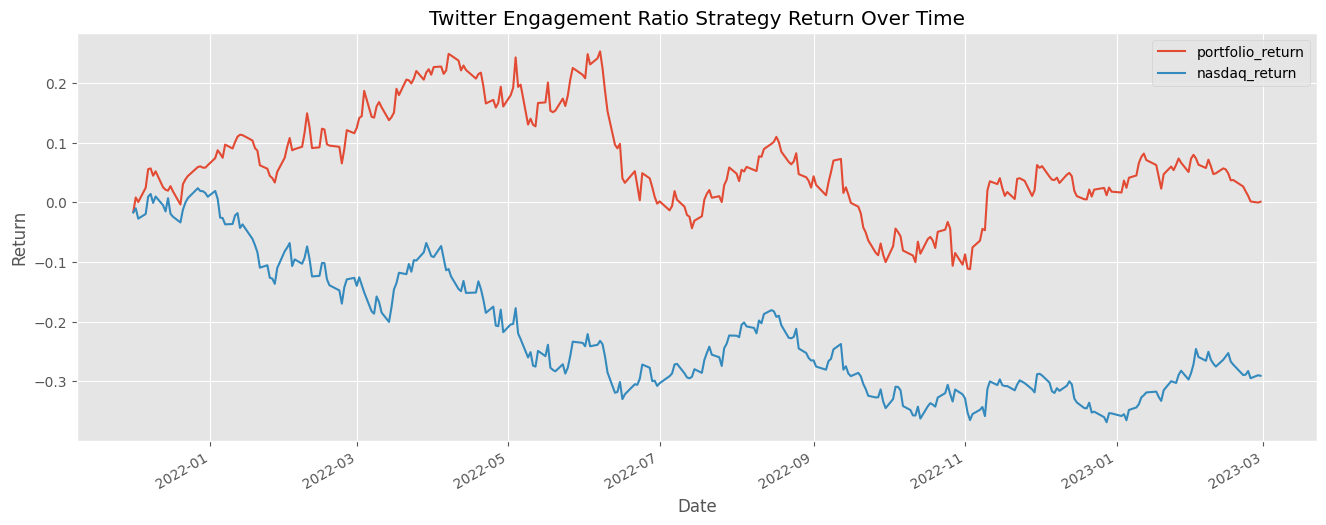

In [ ]:
# Plotting and visualizing return comparison
portfolios_cumlative_return.plot(figsize=(16, 6))
plt.title('Twitter Engagement Ratio Strategy Return Over Time')
plt.ylabel('Return')
plt.show()